# Suicidal Thread Detection in Reddit (Part 1)

The number of countries with national suicide prevention strategies has increased in the five years since the publication of WHO’s first global report on suicide. “Despite progress, one person still dies every 40 seconds from suicide,” said WHO Director-General, Dr Tedros Adhanom Ghebreyesus. Suicide rate is often highest in high-income countries, and it is the second leading cause of death among young people [(WHO, 2019)](https://www.who.int/news-room/detail/09-09-2019-suicide-one-person-dies-every-40-seconds).

With the proliferation of internet in recent decades, more youngsters than ever have been connected to the world wide web. So it would imperative to utilize the power internet to reach out to these vulnerable young people that has suicidal thought. Reddit has been a popular platform for netizens to share their stories or ask for advice. The subreddit of 'Suicide Watch' was created as a platform to empower potential suicide victim, giving them the attention they require and getting them back on the right path.

However, there will be chances that these people have no knowledge of such suicide support-group or simply posted the thread to the wrong subreddit. This would cause the thread to get off the radar of suicide watch and thus the user not received the necessary support from the right community.

So in this project, we set out to create a model to classify thread based on the potential of its content having sign of suicidal thought. We will getting the data from 2 subreddits, one is from the suicide watch of reddit, which will be our positive class (or Class 1). The other subreddit that is used for comparison and as our negative class (Class 0) is the general advice subreddit. Both are similar in nature, with people confessing their problem and sometimes ask for advice from the community. Hence it is expected to show a great contrast.

The suicidal thread detection project will be split into 2 parts, namely Data Collection and Data Analysis for better organization. This notebook, Part 1 would solely be focusing on the extraction and preprocessing of data from the Reddit API. While Part 2 will be focusing on the analysis and modelling part of the project.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Problem-Statement" data-toc-modified-id="Problem-Statement-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Problem Statement</a></span></li><li><span><a href="#Initialization" data-toc-modified-id="Initialization-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Initialization</a></span></li><li><span><a href="#Data-Collection" data-toc-modified-id="Data-Collection-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data Collection</a></span><ul class="toc-item"><li><span><a href="#API-Call-Function" data-toc-modified-id="API-Call-Function-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>API Call Function</a></span></li><li><span><a href="#General-Advice" data-toc-modified-id="General-Advice-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>General Advice</a></span><ul class="toc-item"><li><span><a href="#Boolean-Columns" data-toc-modified-id="Boolean-Columns-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Boolean Columns</a></span></li><li><span><a href="#Object-Columns" data-toc-modified-id="Object-Columns-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Object Columns</a></span></li><li><span><a href="#Numerical-Columns" data-toc-modified-id="Numerical-Columns-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Numerical Columns</a></span></li><li><span><a href="#Feature-Selection-and-Engineering" data-toc-modified-id="Feature-Selection-and-Engineering-3.2.4"><span class="toc-item-num">3.2.4&nbsp;&nbsp;</span>Feature Selection and Engineering</a></span></li></ul></li><li><span><a href="#Suicidal-Watch-Subreddit" data-toc-modified-id="Suicidal-Watch-Subreddit-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Suicidal Watch Subreddit</a></span></li><li><span><a href="#Merging-of-Dataset" data-toc-modified-id="Merging-of-Dataset-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Merging of Dataset</a></span></li></ul></li><li><span><a href="#Exploratory-Data-Analysis" data-toc-modified-id="Exploratory-Data-Analysis-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Exploratory Data Analysis</a></span></li><li><span><a href="#Text-Processing" data-toc-modified-id="Text-Processing-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Text Processing</a></span><ul class="toc-item"><li><span><a href="#Final-Dataset" data-toc-modified-id="Final-Dataset-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Final Dataset</a></span></li><li><span><a href="#Control-Set-with-Data-Leakage" data-toc-modified-id="Control-Set-with-Data-Leakage-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Control Set with Data Leakage</a></span></li></ul></li></ul></div>

## Problem Statement

Despite international effort to curb suicide activities, one person still dies every 40 seconds from commmiting suicide. With the rise of internet proliferation, people are moving online to look for advice or emotional support. However, sometimes it might be tagged wrongly - or deliberately - and fall into the other subreddit. Hence, we aim to create a machine learning model that is able to capture any suicidal thread that ended up in the wrong place and transferring them to the care of suicide watcher.

## Initialization

In [1]:
# Vanilla Libraries

import requests
import time
import random
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 999)

## Data Collection

As explained earlier, the dataset will be collected from Reddit API based on the subreddit that are selected for analysis. For this project, we will be focusing only on the general advice subreddit (r/Advice) and suicidal-watch support group (r/SuicideWatch). 'Advice' will be used as a control class to train our model to differentiate between thread with suicidal thought and those without. Thus, here on Advice will be classified as 0, while SuicideWatch as 1.

### API Call Function

For the application to perform API call and data storage, I have resorted to creating a function for the ease of future modification or tuning. The function would take in a subreddit url for requests, csv filename to export, a maximum loop and target post number to prevent multiple duplicated return from the API.

We are expecting to run for 12 loops, with a maximum return of 1,000 posts for each subreddit. After which we will clean up the data and combine the 2 dataset for further analysis.

In [2]:
def thread_digger(url, max_loop=10, filename='data', post_num=1000):
    after = None
    final = pd.DataFrame()
    current_loop = 0

    while (final.shape[0]<=post_num) and (current_loop<max_loop):
        if after == None:
            current_url = url
        else:
            current_url = url + '&after=' + after

        # Try-Except Loop to catch any connection error
        try:
            res = requests.get(current_url, headers={'User-agent': 'Pony Inc 1.0'})

            # Break right after code 200
            if res.status_code != 200:
                print('Status error', res.status_code)
                break

            current_dict = res.json()
            current_posts = [p['data'] for p in current_dict['data']['children']]
            after = current_dict['data']['after']

            # Concatenation and Export of Dataset
            if current_loop > 0:
                prev_posts = pd.read_csv('./Datasets/' + filename + '.csv')
                current_df = pd.DataFrame(current_posts)
                final = pd.concat([prev_posts, current_df])
                final.drop_duplicates(subset=['title'], inplace=True)
                final.to_csv('./Datasets/' + filename + '.csv', index = False)
                print('\rRound', current_loop+1, 'Completed - Number of Post Collected: ',  end=str(len(final)))
            else:
                pd.DataFrame(current_posts).to_csv('./Datasets/' + filename + '.csv', index = False)
                print('\rRound', current_loop+1, 'Completed - Number of Post Collected: ',  end=str(len(current_posts)))
            
            # Loop Counting
            current_loop+=1
            
            # Sleep only if loop has not finished. Saving previous time.
            if (final.shape[0]<=post_num) and (current_loop<max_loop):
                sleep_duration = random.randint(5,30)
                time.sleep(sleep_duration)
            
        except ConnectionError:
            print('Maximum Entries Exceeded!')
            break
    
    # Indication of Completion
    print('\n')
    return 'Scraping Completed!'

### General Advice

Let's first look into the Advice (0) subreddit. We will do most of the data wrangling and cleaning at this stage. Then the same step will only be applied and repeated for SuicidalWatch (1) subreddit.

In [3]:
# Digging Thread from Reddit API for Class 0
url = "https://www.reddit.com/r/advice/top.json?t=all&limit=100"
thread_digger(url, max_loop=12, filename='advice', post_num=1000)

Round 12 Completed - Number of Post Collected: 980



'Scraping Completed!'

We can see that the there are 980 posts (maybe more, when the code is re-run) in total that we have collected for class 0. However, let's read it into a pandas dataframe and double confirm on the size. Then we will do a sanity check on duplicated rows as well to confirm that our function is working like it should.

In [4]:
advise_df = pd.read_csv('./Datasets/advice.csv')

# Sanity check on shape
advise_df.shape

(980, 103)

In [5]:
# Sanity check on duplicates
advise_df.duplicated(subset=['title']).sum()

0

Great! Our dataset has no duplicates at all. We can proceed to check on the available data and select only the useful data for the next stage of feature engineering.

In [6]:
# Random check on dataset
advise_df.sample(5)

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,subreddit_name_prefixed,hidden,pwls,link_flair_css_class,downs,hide_score,name,quarantine,link_flair_text_color,upvote_ratio,author_flair_background_color,subreddit_type,ups,total_awards_received,media_embed,author_flair_template_id,is_original_content,user_reports,secure_media,is_reddit_media_domain,is_meta,category,secure_media_embed,link_flair_text,can_mod_post,score,approved_by,author_premium,thumbnail,edited,author_flair_css_class,author_flair_richtext,gildings,content_categories,is_self,mod_note,created,link_flair_type,wls,removed_by_category,banned_by,author_flair_type,domain,allow_live_comments,selftext_html,likes,suggested_sort,banned_at_utc,view_count,archived,no_follow,is_crosspostable,pinned,over_18,all_awardings,awarders,media_only,can_gild,spoiler,locked,author_flair_text,treatment_tags,visited,removed_by,num_reports,distinguished,subreddit_id,mod_reason_by,removal_reason,link_flair_background_color,id,is_robot_indexable,report_reasons,author,discussion_type,num_comments,send_replies,whitelist_status,contest_mode,mod_reports,author_patreon_flair,author_flair_text_color,permalink,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,link_flair_template_id,author_cakeday
642,NaN,Advice,NaN,t2_11x9zs,False,NaN,0,False,"Why is it, that I can make friends and acquain...",[],r/Advice,False,0,NaN,0,False,t3_9lwyr7,False,dark,0.98,NaN,public,571,0,{},NaN,False,[],NaN,False,False,NaN,{},NaN,False,571,NaN,False,NaN,False,NaN,[],{},NaN,True,NaN,1.538870e+09,text,0,NaN,NaN,text,self.Advice,True,NaN,NaN,NaN,NaN,NaN,True,False,False,False,False,[],[],False,False,False,False,NaN,[],False,NaN,NaN,NaN,t5_2qjdm,NaN,NaN,NaN,9lwyr7,True,NaN,kkerins86,NaN,28,True,no_ads,False,[],False,NaN,/r/Advice/comments/9lwyr7/why_is_it_that_i_can...,no_ads,False,https://www.reddit.com/r/Advice/comments/9lwyr...,413426,1.538841e+09,0,NaN,False,NaN,NaN
240,NaN,Advice,I (20F) had just gotten home from getting my w...,t2_37gmiojp,False,NaN,0,False,My (20F) mom (46F) read my texts while I was u...,"[{'e': 'text', 't': 'Advice Received'}]",r/Advice,False,0,NaN,0,False,t3_eeokc3,False,light,0.98,#e4e9f2,public,1241,1,{},9a312b9c-6c83-11e9-9b67-0e6ea0218808,False,[],NaN,False,False,NaN,{},Advice Received,False,1241,NaN,False,NaN,1577164869.0,badge,"[{'e': 'text', 't': 'Helper [3]'}]",{'gid_1': 1},NaN,True,NaN,1.577155e+09,richtext,0,NaN,NaN,richtext,self.Advice,True,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,NaN,NaN,NaN,False,False,False,False,False,"[{'giver_coin_reward': None, 'subreddit_id': N...",[],False,False,False,False,Helper [3],[],False,NaN,NaN,NaN,t5_2qjdm,NaN,NaN,#0079d3,eeokc3,True,NaN,gumboslut,NaN,176,True,no_ads,False,[],False,dark,/r/Advice/comments/eeokc3/my_20f_mom_46f_read_...,no_ads,False,https://www.reddit.com/r/Advice/comments/eeokc...,413426,1.577126e+09,0,NaN,False,14ec75f0-6c87-11e9-aff0-0eff25cc8094,NaN
907,NaN,Advice,We live In California btw...\nSo my mom is try...,NaN,False,NaN,0,False,Mom is planning a beach vacation for spring br...,[],r/Advice,False,0,NaN,0,False,t3_fulgtq,False,dark,0.97,NaN,public,234,0,{},NaN,False,[],NaN,False,False,NaN,{},NaN,False,234,NaN,NaN,NaN,False,NaN,NaN,{},NaN,True,NaN,1.585995e+09,text,0,NaN,NaN,NaN,self.Advice,False,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,NaN,NaN,NaN,False,False,False,False,False,[],[],False,False,False,False,NaN,[],False,NaN,NaN,NaN,t5_2qjdm,NaN,NaN,NaN,fulgtq,True,NaN,[deleted],NaN,62,True,no_ads,False,[],NaN,dark,/r/Advice/comments/fulgtq/mom_is_planning_a_be...,no_ads,False,https://www.reddit.com/r/Advice/comments/fulgt...,413427,1.585966e+09,0,NaN,False,NaN,NaN
806,NaN,Advice,God the shit i have been through in a matter o...,t2_3lmbjsns,False,NaN,0,False,I just had a car accident yesterday and almost...,"[{'e': 'text', 't': 'Advice Received'}]",r/Advice,False,0,NaN,0,False,t3

In [7]:
advise_df['send_replies'].value_counts()

True     969
False     11
Name: send_replies, dtype: int64

From the output above, we can see that there are many missing values in the dataset, however, these might not be considered useful information for our analysis. Let's find out more about each of the columns

In [8]:
# Missing Data Percentage
missing_data = advise_df.isnull().sum()/advise_df.shape[0]
missing_data[missing_data>0.4].sort_values()

link_flair_text                  0.616327
link_flair_template_id           0.639796
link_flair_background_color      0.787755
link_flair_css_class             0.834694
author_flair_text_color          0.850000
author_flair_text                0.924490
author_flair_background_color    0.924490
author_flair_template_id         0.924490
author_flair_css_class           0.924490
author_cakeday                   0.993878
distinguished                    0.998980
discussion_type                  1.000000
removal_reason                   1.000000
mod_reason_by                    1.000000
num_reports                      1.000000
media                            1.000000
removed_by                       1.000000
report_reasons                   1.000000
approved_at_utc                  1.000000
banned_at_utc                    1.000000
suggested_sort                   1.000000
banned_by                        1.000000
removed_by_category              1.000000
mod_note                         1

We can see that many of the columns are totally empty. They would not be contributing to our analysis. We will proceed to drop them from the dataset to focus our sight on the rest.

In [9]:
# Dropping heavily-missing columns
drop_cols = missing_data[missing_data>0.4].index
advise_df.drop(drop_cols, axis=1, inplace=True)

In [10]:
# Datatype and Count
advise_df.dtypes.value_counts()

object     32
bool       26
int64      10
float64     3
dtype: int64

After dropping off some columns, we are still left with many. Let's zoom into each of the categories to look out for useful information.

#### Boolean Columns

In [11]:
# Boolean Columns
advise_df.select_dtypes(include='bool').columns

Index(['saved', 'clicked', 'hidden', 'hide_score', 'quarantine',
       'is_original_content', 'is_reddit_media_domain', 'is_meta',
       'can_mod_post', 'is_self', 'allow_live_comments', 'archived',
       'no_follow', 'is_crosspostable', 'pinned', 'over_18', 'media_only',
       'can_gild', 'spoiler', 'locked', 'visited', 'is_robot_indexable',
       'send_replies', 'contest_mode', 'stickied', 'is_video'],
      dtype='object')

From the column name, we can see that these boolean columns would not proved to be useful at all to our analysis and detection of suicidal-prone thread. They are mainly the setting or status of each posts. We will drop it totally.

In [12]:
# Dropping boolean columns
drop_cols = advise_df.select_dtypes(include='bool').columns
advise_df.drop(drop_cols, axis=1, inplace=True)

#### Object Columns

Now let's check out on the column with object. This should be our main target as we are analyzing the content of each posts to classify them.

In [13]:
advise_df.select_dtypes(include='object').head()

,subreddit,selftext,author_fullname,title,link_flair_richtext,subreddit_name_prefixed,name,link_flair_text_color,subreddit_type,media_embed,user_reports,secure_media_embed,author_premium,edited,author_flair_richtext,gildings,link_flair_type,author_flair_type,domain,selftext_html,all_awardings,awarders,treatment_tags,subreddit_id,id,author,whitelist_status,mod_reports,author_patreon_flair,permalink,parent_whitelist_status,url
0,Advice,So I'm [16M]. A while back there was this big ...,t2_11ruag,Falsely accused of rape,[],r/Advice,t3_a0iooj,dark,public,{},[],{},False,False,[],{},text,text,self.Advice,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",[],[],[],t5_2qjdm,a0iooj,Ricardo406,no_ads,[],False,/r/Advice/comments/a0iooj/falsely_accused_of_r...,no_ads,https://www.reddit.com/r/Advice/comments/a0ioo...
1,Advice,NaN,NaN,"I'm Chilean, as i type this on reddit policeme...",[],r/Advice,t3_dkftg1,dark,public,{},[],{},NaN,False,NaN,"{'gid_1': 1, 'gid_2': 1}",text,NaN,self.Advice,NaN,"[{'giver_coin_reward': None, 'subreddit_id': N...",[],[],t5_2qjdm,dkftg1,[deleted],no_ads,[],NaN,/r/Advice/comments/dkftg1/im_chilean_as_i_type...,no_ads,https://www.reddit.com/r/Advice/comments/dkftg...
2,Advice,I can't believe on the stupidity of this situa...,t2_15338o,"I'm gonna be exposed to COVID-19, what should ...","[{'e': 'text', 't': 'Advice Received'}]",r/Advice,t3_fo3l6h,light,public,{},[],{},False,1585477079.0,[],"{'gid_1': 1, 'gid_2': 1}",richtext,text,self.Advice,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...","[{'giver_coin_reward': None, 'subreddit_id': N...",[],[],t5_2qjdm,fo3l6h,ATIR-AW,no_ads,[],False,/r/Advice/comments/fo3l6h/im_gonna_be_exposed_...,no_ads,https://www.reddit.com/r/Advice/comments/fo3l6...
3,Advice,"I need some advice. I am so outraged, so livi...",t2_2fk8oqbl,"My brother, who *hated* religion, died Saturda...",[],r/Advice,t3_9z2jff,dark,public,{},[],{},False,False,[],{'gid_1': 1},text,text,self.Advice,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...","[{'giver_coin_reward': None, 'subreddit_id': N...",[],[],t5_2qjdm,9z2jff,Kaele_Dvaughn,no_ads,[],False,/r/Advice/comments/9z2jff/my_brother_who_hated...,no_ads,https://www.reddit.com/r/Advice/comments/9z2jf...
4,Advice,"They met through a summer camp two years ago, ...",t2_6benqs71,My 14 year old sister is in a ‘non sexual rela...,[],r/Advice,t3_g8ukix,dark,public,{},[],{},False,False,[],{},text,text,self.Advice,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...","[{'giver_coin_reward': 0, 'subreddit_id': None...",[],[],t5_2qjdm,g8ukix,throwaway1175559,no_ads,[],False,/r/Advice/comments/g8ukix/my_14_year_old_siste...,no_ads,https://www.reddit.com/r/Advice/comments/g8uki...


From the table above, we can see that there are only 3 columns that we need for analysis:
1. subreddit - Subreddit name of the post. Our target variable.
2. selftext - Content of the post
3. title - Title of the post

Let's assign these columns into a variable for selection later on.

In [14]:
# Selected object columns
object_cols = ['subreddit', 'selftext', 'title']

#### Numerical Columns

Last but not least, we have to check out on the numerical columns, maybe there are information that might provide insights into the different subreddit. Shining light on the type of community each has.

In [15]:
advise_df.select_dtypes(include='number').head()

,gilded,pwls,downs,upvote_ratio,ups,total_awards_received,score,created,wls,num_comments,subreddit_subscribers,created_utc,num_crossposts
0,0,0,0,0.90,9366,0,9366,1.543262e+09,0,21,413426,1.543233e+09,1
1,1,0,0,0.95,7788,2,7788,1.571580e+09,0,768,413426,1.571552e+09,3
2,1,0,0,0.98,6828,7,6828,1.585078e+09,0,713,413426,1.585049e+09,2
3,0,0,0,0.89,6643,1,6643,1.542830e+09,0,1065,413426,1.542801e+09,1
4,0,0,0,0.97,5860,1,5860,1.587995e+09,0,244,413426,1.587966e+09,2


After looking through the data available, there are only 4 columns that has potential for analysis, namely:
1. upvote_ratio - Percentage of upvote in total votes
2. ups - Number of upvote per post
3. num_comments - Number of comments in each post
4. subreddit_subscribers - Number of subscribers at the time of posting

Same as above, we will assign these columns to a temporary variable for feature selection.

In [16]:
# Selected numerical columns
numerical_cols = ['upvote_ratio', 'ups', 'num_comments', 'subreddit_subscribers']

#### Feature Selection and Engineering

Now that we have shortlisted the columns we need for the analysis. Let's create a new dataframe for feature engineering. Since there are many selftext that are empty, we may simply concatenate each title and selftext to form a full textual data. This would make tokenization and analysis easier at the next stage. Then, we would create a new binary column called **suicidal** to mark the class of these posts, which will later be our target variable.

In [17]:
# Creation of DataFrame with selected columns
advise_final = advise_df[object_cols + numerical_cols].copy()

# Check on missing value
advise_final.isnull().sum()

subreddit                 0
selftext                 42
title                     0
upvote_ratio              0
ups                       0
num_comments              0
subreddit_subscribers     0
dtype: int64

In [18]:
# Fill all missing value in selftext with empty string for concat later on
advise_final['selftext'].fillna('', inplace=True)

# Concat of title to selftext
advise_final['text'] = advise_final['title'] + ' ' + advise_final['selftext']

# Creation of target variable
advise_final['suicidal'] = 0

# Drop off the pre-engineered columns
advise_final.drop(['selftext','title','subreddit'], axis=1, inplace=True)

In [19]:
# Sanity check on the final dataframe
advise_final.sample(5)

,upvote_ratio,ups,num_comments,subreddit_subscribers,text,suicidal
542,0.99,724,147,413426,"On vacation solo, I have no fuckin clue what I...",0
655,0.98,540,80,413426,How can I stop having emotional reaction to ev...,0
571,0.99,682,130,413426,My Friend is Having Sex With His Imaginary Fri...,0
62,0.98,2117,121,413426,30 min ago i admitted to my wife that i have a...,0
480,0.97,838,88,413426,My twin committed suicide about three weeks ag...,0


Everything looks good to go. We may move on to our class 1, Suicidal Watch with the exact same steps after feature selection.

### Suicidal Watch Subreddit

Now we will collect data for our class 1, with the same aim to collecting data close to 1,000 posts.

In [20]:
url = "https://www.reddit.com/r/SuicideWatch/top.json?t=all&limit=100"
thread_digger(url, max_loop=12, filename='suicidal', post_num=1000)

Round 12 Completed - Number of Post Collected: 983



'Scraping Completed!'

In [21]:
# Digging Thread from Reddit API for Class 1
suicide_df = pd.read_csv('./Datasets/suicidal.csv')

In [22]:
# Emulating the same steps we have done for Class 0
suicide_final = suicide_df[object_cols + numerical_cols].copy()
suicide_final['selftext'].fillna('', inplace=True)
suicide_final['text'] = suicide_final['title'] + ' ' + suicide_final['selftext']
suicide_final['suicidal'] = 1
suicide_final.drop(['selftext','title','subreddit'], axis=1, inplace=True)

In [23]:
# Sanity check on our dataset
suicide_final.sample(5)

,upvote_ratio,ups,num_comments,subreddit_subscribers,text,suicidal
186,0.99,644,50,200930,I fucking hate my birthday You don't give a sh...,1
282,0.99,531,65,200930,Anyone else waiting on parents to die so they ...,1
734,0.99,223,45,200930,"“If you feel suicidal, call the suicide hotlin...",1
421,0.99,413,80,200930,Life is pain. And then you die. It’s time to f...,1
430,0.99,397,58,200930,Is anyone else tired of life but too scared to...,1


### Merging of Dataset

Now that we have both the subreddit thread collected, we can now merge them to form the final dataset.

In [24]:
final_df = pd.concat([advise_final, suicide_final], axis=0).reset_index(drop=True)

In [25]:
# Sanity check on the final dataset
final_df.sample(5)

,upvote_ratio,ups,num_comments,subreddit_subscribers,text,suicidal
1517,0.99,322,64,200930,Do you ever get sudden compulsive urges to kil...,1
1539,1.00,306,23,200930,Self hatred Every little thing I do wrong make...,1
6,0.95,5182,1106,413426,Is it ok to dump girlfriend because she's not ...,0
925,0.95,229,77,413427,Is my bf's family using me after his father di...,0
240,0.98,1241,176,413426,My (20F) mom (46F) read my texts while I was u...,0


## Exploratory Data Analysis

Before we move into Natural Language Processing (NLP), let's perform some Exploratory Data Analysis (EDA) on the dataset to understand the demographics or rather behaviour of each community within each subreddit. Hopefully we may find some key difference or insights between each group of subscribers.

In [26]:
final_df.groupby('suicidal').mean()

,upvote_ratio,ups,num_comments,subreddit_subscribers
suicidal,,,,
0,0.965796,970.721429,185.514286,413426.285714
1,0.985727,455.826043,59.700916,200930.000000


If we are just looking the numbers above, we can see the following points:
1. Class 1 (Suicide Watch) has less than half of subscribers comparing to Class 0 (Advice)
2. The number of comments per post is less than 1/3, very stark contrast in between
3. Albeit Class 0 having a higher upvote count, it has a lower upvote ratio than Class 1

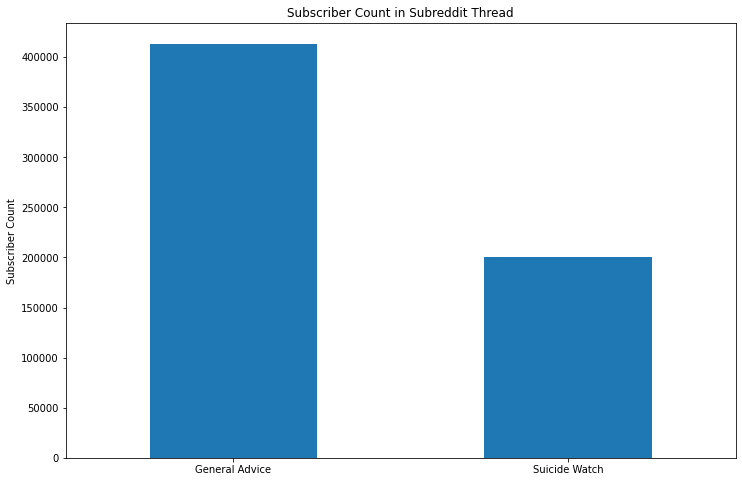

In [27]:
plt.figure(figsize=(12,8))
final_df.groupby('suicidal').mean()['subreddit_subscribers'].plot(kind='bar')

plt.xticks(rotation=0)
plt.title('Subscriber Count in Subreddit Thread')
plt.xticks(ticks=[0, 1], labels=['General Advice', 'Suicide Watch'])
plt.xlabel('')
plt.ylabel('Subscriber Count')
plt.savefig('./Images/subscriber.png')

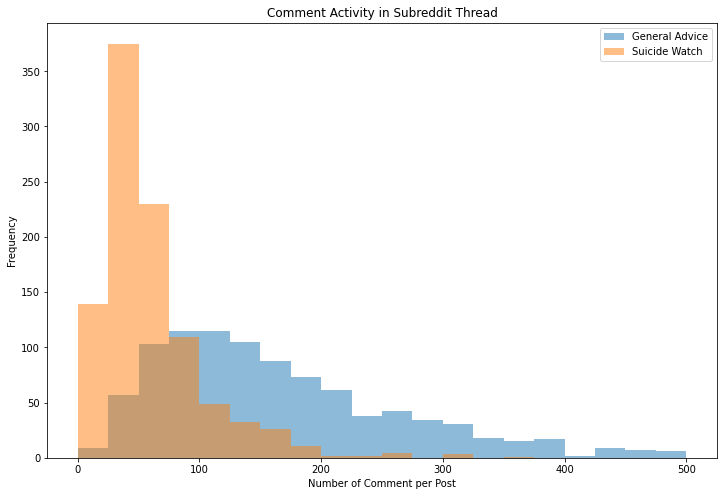

In [28]:
plt.figure(figsize=(12,8))
advise_final['num_comments'].plot.hist(label='General Advice', range=(0,500), bins=20, alpha=0.5)
suicide_final['num_comments'].plot.hist(label='Suicide Watch', range=(0,500), bins=20, alpha=0.5)
plt.xlabel('Number of Comment per Post')
plt.title('Comment Activity in Subreddit Thread')
plt.legend()
plt.savefig('./Images/comment_activity_comparison.png')

In [29]:
print('Minimum Comment for Class 0: ', advise_final['num_comments'].min())
print('Minimum Comment for Class 1: ', suicide_final['num_comments'].min())

Minimum Comment for Class 0:  4
Minimum Comment for Class 1:  2


As we may see from the comparison above, we can see that generally Class 0 has much more comments than Class 1. However, this might have something to do with the number of subscribers at each end. Besides, we can see that both the minimum comment count for each class is not zero, which shows both the community to be quite supportive.

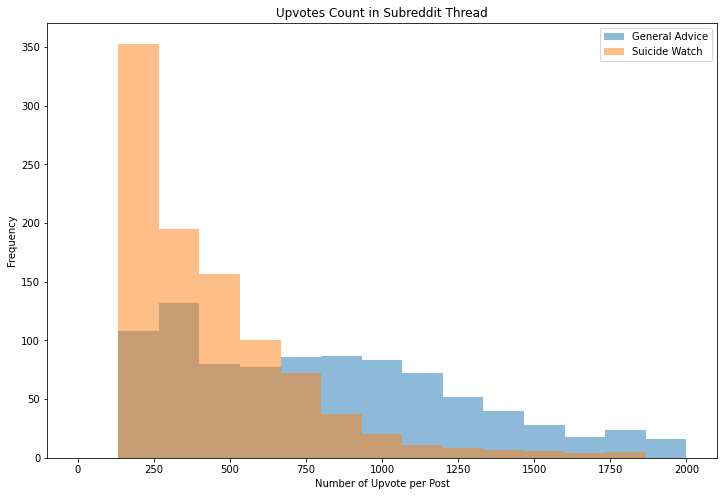

In [30]:
plt.figure(figsize=(12,8))
advise_final['ups'].plot.hist(label='General Advice', range=(0,2000), bins=15, alpha=0.5)
suicide_final['ups'].plot.hist(label='Suicide Watch', range=(0,2000), bins=15, alpha=0.5)

plt.xlabel('Number of Upvote per Post')
plt.title('Upvotes Count in Subreddit Thread')
plt.legend()
plt.savefig('./Images/upvotes_comparison.png')

In [31]:
perc_0 = advise_final['ups'].min() / advise_final['subreddit_subscribers'].mean()
perc_1 = suicide_final['ups'].min() / suicide_final['subreddit_subscribers'].mean()
print('Minimum Upvote in Class 0 in term of percentage of subscribers: ', round(perc_0 * 100, 2), '%')
print('Minimum Upvote in Class 1 in term of percentage of subscribers: ', round(perc_1 * 100, 2), '%')

Minimum Upvote in Class 0 in term of percentage of subscribers:  0.05 %
Minimum Upvote in Class 1 in term of percentage of subscribers:  0.08 %


Very similar to the distribution in number of comments, Class 0 has much more upvotes than Class 1, which is tightly associated with the number of subscriber in each subreddit. However, if we were to find out the minimum upvoted post in the subreddit, and divide it with the number of subscribers in each community, we can see that subscribers in Class 1 are marginally more active in giving each post sufficient attention than Class 0.

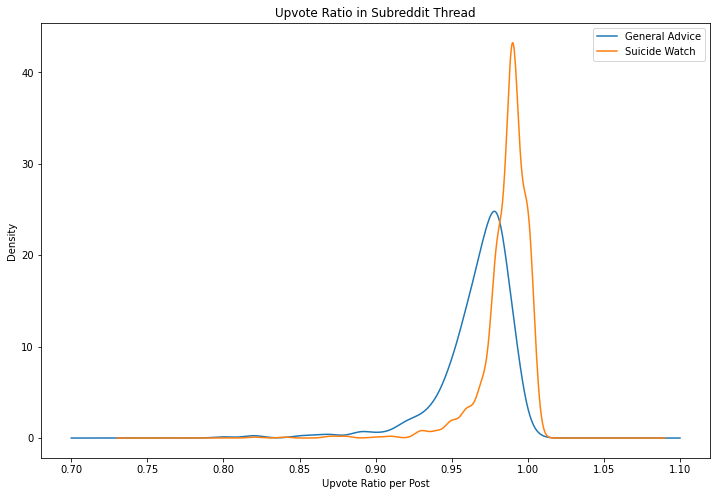

In [32]:
plt.figure(figsize=(12,8))
advise_final['upvote_ratio'].plot.kde(label='General Advice')
suicide_final['upvote_ratio'].plot.kde(label='Suicide Watch')

plt.xlabel('Upvote Ratio per Post')
plt.title('Upvote Ratio in Subreddit Thread')
plt.legend()
plt.savefig('./Images/upvotes_ratio.png')

Now we can finally a key difference between the community of each subreddit. It appeared that almost all of the posts in Class 1 has a near-100% upvote ratio, and it has smaller spread than Class 0. It shows that community in Class 1 are more positive in feedback to each post than Class 0, showing the much needed compassion towards people with suicidal thought.

## Text Processing

Now we may move into the text processing part of our project. We will be using NLP technique to tokenize and clean up the textual data in our datasets.

In [33]:
# Glance on the text data
final_df['text'].sample(5)

670     Help, lost my health insurance I am kind of SO...
993     New wiki on how to avoid accidentally encourag...
1158    I wish I could give someone else my life Some ...
1365    I have never had affection in my life, respect...
333     Just got out of prison after almost 4 years. H...
Name: text, dtype: object

In [34]:
def robust_text_prep(words, control_set=False):
    
    # Define stop word to avoid data leakage
    leakage_words = ['suicide', 'suicidal', 'advice', 'advise']
    
    # Import of necessary dependencies
    from nltk.tokenize import RegexpTokenizer
    from nltk.stem import WordNetLemmatizer
    from nltk.corpus import stopwords
    from nltk.stem.porter import PorterStemmer

    # convert all text to lowercase,
    words = words.lower()
    
    # remove punctuation,
    tokenizer = RegexpTokenizer(r'[a-z]+')
    words = tokenizer.tokenize(words)
    
    # remove stopwords for non-control set.
    if control_set:
        words = [word for word in words if word not in stopwords.words('english')]
    else:
        words = [word for word in words if word not in stopwords.words('english')+leakage_words]
    
    # stem or lemmatize each word of the text,
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    
    # Return the final string
    return ' '.join(words)

In [35]:
# Test Run
robust_text_prep("HELP, I WANT TO KILLs killing MySELF suicide suicidal, any advice?")

'help want kill kill'

In [36]:
robust_text_prep("HELP, I WANT TO KILLs killing MySELF suicide suicidal, any advice?",
                control_set=True)

'help want kill kill suicid suicid advic'

### Final Dataset

In [37]:
cleaned_text = final_df['text'].apply(robust_text_prep)
export_df = final_df.copy()
export_df['text'] = cleaned_text
export_df['full_text'] = final_df['text']
export_df.sample(5)

,upvote_ratio,ups,num_comments,subreddit_subscribers,text,suicidal,full_text
1019,0.99,1179,30,200930,call hotlin thank tom call hotlin sad long tim...,1,"Just called suicide hotline. Thanks, Tom. I ca..."
1714,0.99,223,45,200930,feel call hotlin deal constantli hear see long...,1,"“If you feel suicidal, call the suicide hotlin..."
247,0.99,1228,116,413426,give eight year old son worst news life go pa ...,0,How should I give my eight year old son the wo...
470,0.98,852,218,413426,go jail terrifi decemb fifth forc serv minimum...,0,Going to jail and terrified On december fifth ...
680,0.99,497,53,413426,look old elementari school googl earth think r...,0,I was looking at at my old elementary school o...


In [38]:
export_df.to_csv('./Datasets/cleaned_data.csv', index=False)

### Control Set with Data Leakage

In [39]:
control_set_df = final_df.copy()
control_set_text = final_df['text'].apply(robust_text_prep, control_set=True)
control_set_df['text'] = control_set_text
control_set_df['full_text'] = final_df['text']
control_set_df.sample(5)

,upvote_ratio,ups,num_comments,subreddit_subscribers,text,suicidal,full_text
1029,1.00,1061,50,200930,hate depress forget everyth forget stuff forge...,1,I hate how when you’re depressed you just forg...
114,0.97,1739,328,413426,overreact yr old girl went sleepov best friend...,0,Did I overreact? I'm a 16 yr old girl and I we...
144,0.99,1567,204,413426,littl cousin f joke flash cousin get along rea...,0,My little cousin [7/F] is joking about me flas...
1335,0.98,459,85,200930,anyon els feel like commit suicid get reveng p...,1,Does anyone else feel like they have to commit...
582,0.98,673,109,413426,crazi guy keep knock door everyday wait porch ...,0,This is crazy but this guy keeps knocking on o...


In [40]:
control_set_df.to_csv('./Datasets/control_set_data.csv', index=False)

Here is the end of the first part. Further analysis and modelling attempt will be carried out and reported in Part 2.